# <font color='blue'>Introduction to Sparsity</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Time-Frequency Example](#Time-Frequency-Example)
1. [Sparsity](#Sparsity)
 * [Sparse Representation](#Sparse-Representation)
 * [Measures of Sparsity](#Measures-of-Sparsity)
 * [Promoting Sparsity](#Promoting-Sparsity)
1. [Denoising Exercise](#Denoising-Exercise)
1. [Inpainting Exercise](#Inpainting-Exercise)
1. [Hints](#Hints)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [15]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy import fftpack

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

# Function to calculate an orthonormal descrete cosine transform.
def dct(signal):

    return fftpack.dct(signal, norm='ortho')

# Function to calculate an orthonormal descrete cosine transform.
def idct(signal):

    return fftpack.idct(signal, norm='ortho')

# Function to calculate an orthonormal inverse descrete cosine transform.
def mad(signal):
    
    return np.median(np.abs(signal - np.median(signal)))

## <font color='blue'>Introduction</font>

---

A sparse signal is one that is comprised mostly of zeros when expressed in the appropriate basis.

## <font color='blue'>Time-Frequency Example</font>

---

Let's start with a simple sine wave example. We have a time series signal where

$$y = \sin(t)$$

with a sampling rate of 50 and a frequency of 2. We can display this function as follows:

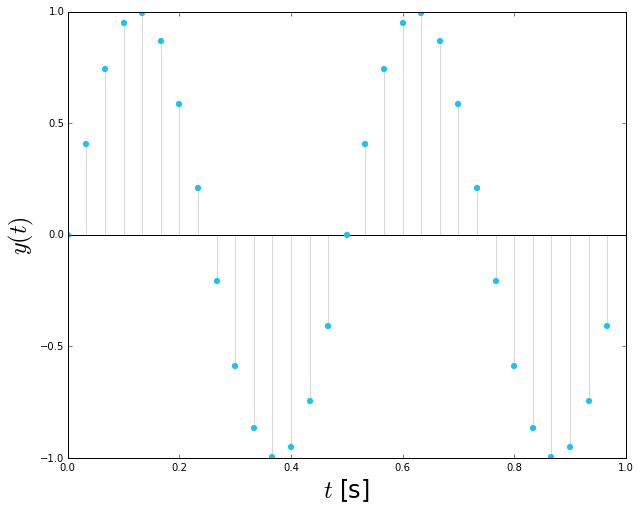

In [2]:
# Set the signal properties.
sampling_rate = 30.0
frequency = 2

# Set a range of t values.
t = np.arange(0, 1, 1.0 / sampling_rate)

# Get the corresponding y values.
y = np.sin(2 * np.pi * frequency * t)

# Display
plt.plot((t, t), (np.zeros(y.size), y), '-', color='#D8D8D8')
plt.plot((0.0, 1.0), (0.0, 0.0), 'k-')
plt.plot(t, y, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$t$ [s]', fontsize=24)
plt.ylabel('$y(t)$', fontsize=24)
plt.show()

We can clearly see that the signal is not sparse as the majority of coefficients are non-zero. However, if we the frequency component of this signal it becomes very sparse indeed.

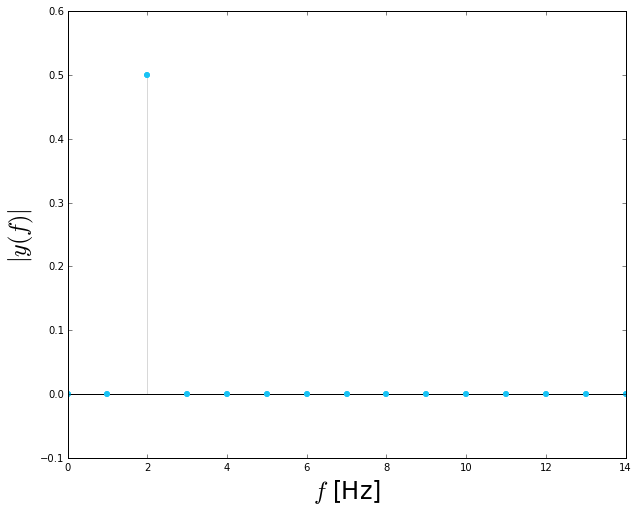

In [3]:
# Get the one-sided frequency range.
f = np.arange(y.size) * sampling_rate / y.size 
f = f[:y.size / 2]

# Calculate the normalised FFT of the signal.
y_fft = np.abs(np.fft.fft(y)) / y.size 
y_fft = y_fft[:y.size / 2]

# Display
plt.plot((f, f), (np.zeros(y_fft.size), y_fft), '-', color='#D8D8D8')
plt.plot((0.0, max(f)), (0.0, 0.0), 'k-')
plt.plot(f, y_fft, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$f$ [Hz]', fontsize=24)
plt.ylabel('$|y(f)|$', fontsize=24)
plt.ylim(-0.1, 0.6)
plt.show()

Now, we have only a single coefficient which is non-zero. So, although in its natural domain our signal does not appear to be sparse we were able to find a sparse representation in a different basis.

So, how can the knowledge that a given signal is sparse in a given domain be useful?

## <font color='blue'>Sparsity</font>

---

We can use the knowledge that a signal is sparse in a given domain as prior knowledge when solving an inverse problem. This enables us to reduce the parameters space and allows us to converge upon a better and simpler solution.



### <font color='green'>Sparse Representation</font>

A signal $x$ can be respresented as

$$x = \phi\alpha = \sum_{i=1}^n\phi_i\alpha_i$$

where $\alpha$ are the coefficients of $x$ in the dictionary $\phi$. 

### <font color='green'>Measures of Sparsity</font>

The true sparsity of a signal can be measured with the $l_0$ pseudo-norm.

$$\|x\|_0 = \text{Card}(\text{Supp}(x))$$

*i.e.* the number of non-zero elements in the signal. However, this function is non-convex and is computationally hard  to solve. Therefore, in practice the convex $l_1$ norm is used instead.

$$\|x\|_1 = \sum_{i=1}^n |x_i|$$

We can use this to measure the sparsity of our time-frequency example.

In [4]:
# Function to measure the l1 norm.
def l1_norm(signal):
    
    return np.sum(np.abs(signal))

# Get the l1 norm of the time and frequency signals.
print 'The l1 norm of the time signal:', l1_norm(y)
print 'The l1 norm of the frequency signal:', l1_norm(y_fft)

The l1 norm of the time signal: 19.0287289084
The l1 norm of the frequency signal: 0.5


As expected the frequency signal is significantly more sparse.

### <font color='green'>Promoting Sparsity</font>

In order to actually produce solutions that are more sparse one typically performs a thresholding operation in the sparse domain. Standard techniques include hard and soft thresholding.

**Hard Thresholding**

$$HT_{\lambda}(x_i) = \begin{cases} x_i & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

**Soft Thresholding**

$$ST_{\lambda}(x_i) = \begin{cases} x_i - \lambda\text{sign}(x_i) & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

The threshold value, $\lambda$, will vary depending on the type of problem. In the case of denoising $\lambda$ represents an estimate of the noise in the sparse domain. 

In [41]:
# Function for perfoming hard thresholding.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Function for perfoming soft thresholding.
def soft_thresh(signal, threshold):
    
    return np.sign(signal) * (np.abs(signal) - threshold) * (np.abs(signal) >= threshold)

# Define a random signal.
np.random.seed(2)
x = np.random.ranf((5, 5))

# Set the threshold.
thresh = 0.6

# Threshold the signal.
x_thresh_hard = hard_thresh(x, thresh)
x_thresh_soft = soft_thresh(x, thresh)

print 'Original Signal.'
print ''
print x
print ''
print 'l1 norm:', l1_norm(x)
print ''
print ''
print 'Hard Thresholded Signal.'
print ''
print x_thresh_hard
print ''
print 'l1 norm:', l1_norm(x_thresh_hard)
print ''
print ''
print 'Soft Thresholded Signal.'
print ''
print x_thresh_soft
print ''
print 'l1 norm:', l1_norm(x_thresh_soft)


Original Signal.

[[ 0.4359949   0.02592623  0.54966248  0.43532239  0.4203678 ]
 [ 0.33033482  0.20464863  0.61927097  0.29965467  0.26682728]
 [ 0.62113383  0.52914209  0.13457995  0.51357812  0.18443987]
 [ 0.78533515  0.85397529  0.49423684  0.84656149  0.07964548]
 [ 0.50524609  0.0652865   0.42812233  0.09653092  0.12715997]]

l1 norm: 9.8529840857


Hard Thresholded Signal.

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.61927097  0.          0.        ]
 [ 0.62113383  0.          0.          0.          0.        ]
 [ 0.78533515  0.85397529  0.          0.84656149  0.        ]
 [ 0.          0.          0.          0.          0.        ]]

l1 norm: 3.72627672493


Soft Thresholded Signal.

[[-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.          0.01927097 -0.         -0.        ]
 [ 0.02113383 -0.         -0.         -0.         -0.        ]
 [ 0.18533515  0.25397529 -0.          0.24656149 -0.     

### <font color='green'>Sparse Regularisation</font>

Recall that for solving an inverse problem of the form

$$Y = MX$$

we aimed to minimise a function of the following form

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|Y-MX\|_2^2\end{aligned}$$

Now, if we know that $X$ is sparse in the domain $X = \phi\alpha$ we can update our minimisation problems as follows:

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|Y-M\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we now seek a value of $\alpha$ that both minimises the residual and requires that $\alpha$ be sparse. This formulation is generally referred to as a *synthesis prior*. This problem can alternatively be formulated as follows:

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|Y-MX\|_2^2 + \lambda\|\phi^{T}X\|_1\end{aligned}$$

which is referred to as an *analysis prior*. When $\phi$ is orthogonal these two formulations are equivalent, when $\phi$ is not orthogonal this is no longer the case. Each approach has certain benefits when applied to different problems, however the analysis approach is generally more flexible.

## <font color='blue'>Denoising Exercise</font>

---

In [44]:
# Define a range of values
t = np.linspace(0, 20 * np.pi, 1000)

# Set the noise level.
sigma = 0.1

# Define the signal.
x = np.sin(t)

# Add noise to the signal.
y = x + sigma * np.random.randn(x.size)

In [47]:
# Get FFT of the signals
x_fft = np.real(np.fft.fft(x))
y_fft = np.real(np.fft.fft(y))

# Estimate the noise in the FFT domain.
noise_est = mad(y_fft) * 10
print 'Noise Estimate =', noise_est

# Perform hard thresholding.
y_rec = np.fft.ifft(hard_thresh(np.fft.fft(y2_obs), noise_est))

Noise Estimate = 13.5740995908


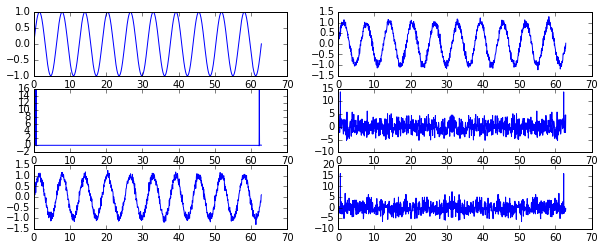

In [46]:
plt.subplot(621)
plt.plot(t, x)
plt.subplot(622)
plt.plot(t, y)
plt.subplot(623)
plt.plot(t, x_fft)
plt.subplot(624)
plt.plot(t, y_fft)
plt.subplot(625)
plt.plot(t, y_rec)
plt.subplot(626)
plt.plot(t, np.real(np.fft.fft(y_rec)))
plt.show()

## <font color='blue'>Inpainting Exercise</font>

---

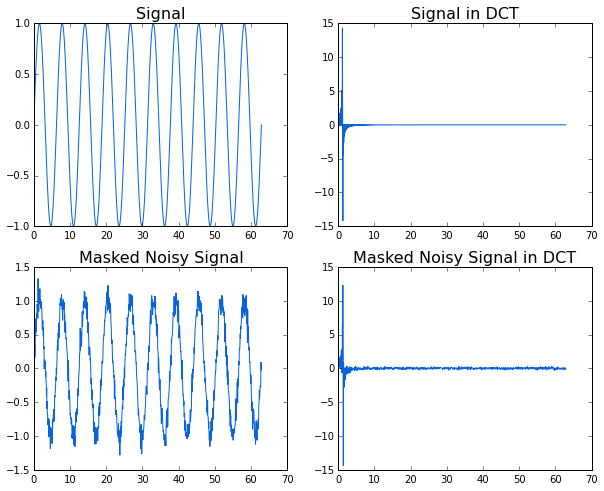

In [38]:
# Function to mask a signal.
def mask_op(signal, mask):
    
    return signal[np.where(mask == 1)[0]]

# Function to upsample a signal.
def mask_op_t(signal, mask):
    
    val = np.copy(mask)
    val[val == 1] *= signal
    return val

# Set the noise level.
sigma = 0.1

# Set the fraction of masked coefficients.
fraction = 0.1

# Set a range of points.
t = np.linspace(0, 20 * np.pi, 1000)

# Create a random mask.
np.random.seed(1)
index = np.random.permutation(np.arange(t.size))[:fraction * t.size]
mask = np.ones(t.size)
mask[index] = 0
t_mask = mask_op(t, mask)

# Define the signal.
x = np.sin(t)
x_dct = dct(x)

# Mask the signal and add Gaussian noise.
y_mask = mask_op(x, mask)
y = y_mask + sigma * np.random.randn(y_mask.size)
y_dct = dct(y)

# Display
plt.subplot(221)
plt.plot(t, x, color='#0764DB')
plt.title('Signal', fontsize=16)
plt.subplot(222)
plt.plot(t, x_dct, color='#0764DB')
plt.title('Signal in DCT', fontsize=16)
plt.subplot(223)
plt.plot(t_mask, y, color='#0764DB')
plt.title('Masked Noisy Signal', fontsize=16)
plt.subplot(224)
plt.plot(t_mask, y_dct, color='#0764DB')
plt.title('Masked Noisy Signal in DCT', fontsize=16)
plt.show()

In [16]:
# Function to calculate the gradient.
def grad(y, alpha_rec, mask):

    return dct(mask_op_t(mask_op(idct(alpha_rec), mask) - y, mask))

# Function to calculate the cost.
def cost_func(y, alpha_rc, mask, noise_est):

    return (0.5 * np.linalg.norm(y - mask_op(idct(alpha_rec), mask)) ** 2 + noise_est * l1_norm(alpha_rec))

# Estimate the noise in the DCT domain.
noise_est = mad(y_dct) * 3
print 'Noise Estimate =', noise_est
print ''

# Start with an initial guess for alpha.
alpha_rec = np.ones(x_dct.size)

# Define gamma. For simplicity we will set it to one.
gamma = 1.0

# Set the number of iterations.
n_iter = 10

# Iterate until we have a solution.
for i in range(n_iter):

    alpha_temp = alpha_rec - gamma * grad(y, alpha_rec, mask)
    alpha_rec = soft_thresh(alpha_temp, noise_est)
    cost = cost_func(y, alpha_rec, mask, noise_est)
    print 'Iteration', i, 'Cost =', cost

Noise Estimate = 0.217803354985

Iteration 0 Cost = 27.1678154899
Iteration 1 Cost = 18.9452160087
Iteration 2 Cost = 18.0623805619
Iteration 3 Cost = 18.0290731639
Iteration 4 Cost = 18.0279756741
Iteration 5 Cost = 18.0279347489
Iteration 6 Cost = 18.0279331468
Iteration 7 Cost = 18.0279330802
Iteration 8 Cost = 18.0279330774
Iteration 9 Cost = 18.0279330773


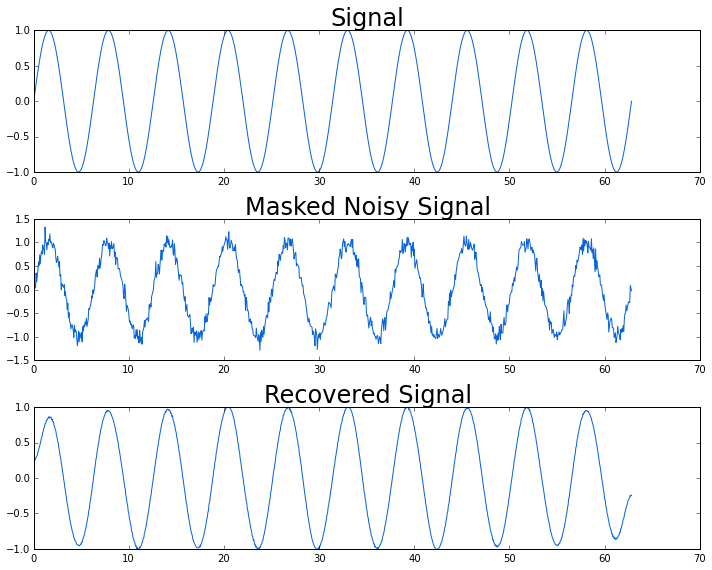

In [33]:
# Display
plt.subplot(311)
plt.plot(t, x, color='#0764DB')
plt.title('Signal', fontsize=24)
plt.subplot(312)
plt.plot(t_mask, y, color='#0764DB')
plt.title('Masked Noisy Signal', fontsize=24)
plt.subplot(313)
plt.plot(t, idct(alpha_rec), color='#0764DB')
plt.title('Recovered Signal', fontsize=24)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()